<a href="https://colab.research.google.com/github/sekheng/MDP_Group34_RobotCats/blob/main/ImageRec2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link files with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1) Install and Import the models

In [ ]:
!pip install -q tflite-model-maker
!pip install -q pycocotools

     |████████████████████████████████| 577 kB 8.2 MB/s 
     |████████████████████████████████| 1.1 MB 48.3 MB/s 
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 3.4 MB 52.1 MB/s 
     |████████████████████████████████| 1.3 MB 47.3 MB/s 
     |████████████████████████████████| 840 kB 75.3 MB/s 
     |████████████████████████████████| 87 kB 6.6 MB/s 
     |████████████████████████████████| 238 kB 56.9 MB/s 
     |████████████████████████████████| 10.9 MB 53.9 MB/s 
     |████████████████████████████████| 128 kB 77.7 MB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 25.3 MB 103.9 MB/s 
     |█████████████████████▏          | 329.4 MB 1.3 MB/s eta 0:02:12

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

#2) Import the data

In [ ]:
! gdown --id 1Oo3xE4xLoLxQWukOxwi6DVkDA8TFAmwA
# ! gdown --id 1lV0Buj7zwy2wBLQiVO3t1zSvS7l0N9rN

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Oo3xE4xLoLxQWukOxwi6DVkDA8TFAmwA
To: /content/mdp.v2-harshmadedataset1.voc.zip
100% 48.5M/48.5M [00:00<00:00, 191MB/s]


In [ ]:
!unzip '/content/mdp.v2-harshmadedataset1.voc' -d '/content/data/'
# !unzip '/Left_Right_Arrow.v1i.voc.zip' -d '/content/data/'

Archive:  /content/mdp.v2-harshmadedataset1.voc.zip
 extracting: /content/data/README.dataset.txt  
 extracting: /content/data/README.roboflow.txt  
   creating: /content/data/train/
 extracting: /content/data/train/2_0_jpg.rf.0866b3f580565a0dab6fe5fbb8228677.jpg  
 extracting: /content/data/train/2_0_jpg.rf.0866b3f580565a0dab6fe5fbb8228677.xml  
 extracting: /content/data/train/2_0_jpg.rf.619756692abe6f8e05c0d8474b44174a.jpg  
 extracting: /content/data/train/2_0_jpg.rf.619756692abe6f8e05c0d8474b44174a.xml  
 extracting: /content/data/train/2_0_jpg.rf.6bc7f620f6b10258604b28e0d2a2edae.jpg  
 extracting: /content/data/train/2_0_jpg.rf.6bc7f620f6b10258604b28e0d2a2edae.xml  
 extracting: /content/data/train/2_10_jpg.rf.3b3650b69d63c51aadb7f099996300e0.jpg  
 extracting: /content/data/train/2_10_jpg.rf.3b3650b69d63c51aadb7f099996300e0.xml  
 extracting: /content/data/train/2_10_jpg.rf.97974b41d86c02870043031d6d6ee5aa.jpg  
 extracting: /content/data/train/2_10_jpg.rf.97974b41d86c0287004303

In [ ]:
labels_dict = {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'bullseye', 13: 'C', 14: 'D', 15: 'Down', 16: 'E', 17: 'F', 18: 'G', 19: 'H', 20: 'Left', 21: 'Right', 22: 'S', 23: 'Stop', 24: 'T', 25: 'U', 26: 'Up', 27: 'V', 28: 'W', 29: 'X', 30: 'Y', 31: 'Z'}
# labels_dict = {1: 'Left', 2: 'Right'}

## Read an Image

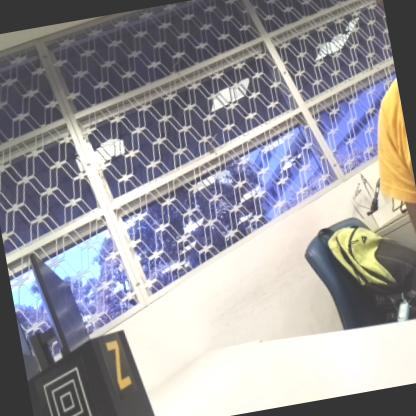

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

cv2_imshow(cv2.imread("/content/data/train/z_5_jpg.rf.f181c12f9e0a6d090692a3601d3ef584.jpg"))

### Converting Images to black and white
(Dont run this section if you want to train in colour)

In [ ]:
import cv2

In [ ]:
imglist = os.listdir("/content/data/train/")
for img_file in imglist:
  if(img_file[-3:] != 'jpg'):
    continue
  img = cv2.imread(("/content/data/train/" + img_file))
  grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(("/content/data/train/" + img_file), grayImage)

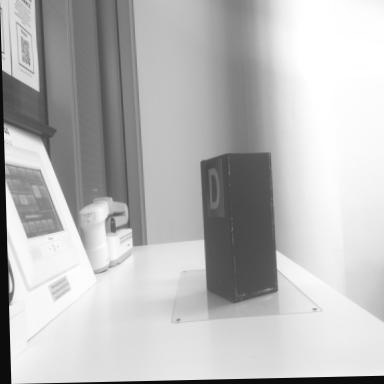

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(cv2.imread("/content/data/train/blue_d_93_jpg.rf.c6d0e9852c7bfacac519982fbde32911.jpg"))

#3) Split the data into Training and Validation Data  
(Test is the actual test from the live Rpi camera feed)

In [ ]:
os.rename('/content/data/train', '/content/data/images')

In [ ]:
import os, random, shutil

os.mkdir('/content/data/train')
os.mkdir('/content/data/valid')

image_paths = os.listdir('/content/data/images')
random.shuffle(image_paths)

for i, image_path in enumerate(image_paths):
  if i < int(len(image_paths) * 0.8):
    shutil.copy(f'/content/data/images/{image_path[:-3]}'+'jpg', '/content/data/train')
    shutil.copy(f'/content/data/images/{image_path[:-3]}'+'xml', '/content/data/train')
  else:
    shutil.copy(f'/content/data/images/{image_path[:-3]}'+'jpg', '/content/data/valid')
    shutil.copy(f'/content/data/images/{image_path[:-3]}'+'xml', '/content/data/valid')

In [ ]:
train_data = object_detector.DataLoader.from_pascal_voc(images_dir='/content/data/train', annotations_dir='/content/data/train', label_map=labels_dict)
val_data = object_detector.DataLoader.from_pascal_voc(images_dir='/content/data/valid', annotations_dir='/content/data/valid', label_map=labels_dict)

In [ ]:
len(train_data)

1963

# 4) Train the model
Do hyperparameter Tuning here and note the results

### Things to try  
1) Increase epochs  
2) Reduce Batch Size (Accuracy vs Training Speed with GPU)  
3) make train_whole_model=False (default) (Increases val_loss)

### Results
1) 25 epochs are enough to reach 0.25 val_loss in effdet1 with train whole model on      
2) 45 epochs are enough to reach 0.20 val_loss in effdet1 with train whole model on      


In [ ]:
spec = model_spec.get('efficientdet_lite1')
spec.config.tflite_max_detections=4

In [ ]:
model = object_detector.create(train_data, model_spec=spec, epochs=80, batch_size=8, train_whole_model=True, validation_data=val_data)

Epoch 1/90
245/245 [==============================] - 100s 252ms/step - det_loss: 1.4253 - cls_loss: 1.1392 - box_loss: 0.0057 - reg_l2_loss: 0.0681 - loss: 1.4935 - learning_rate: 0.0090 - gradient_norm: 2.3134 - val_det_loss: 1.1221 - val_cls_loss: 0.9071 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0682 - val_loss: 1.1903
Epoch 2/90
245/245 [==============================] - 62s 255ms/step - det_loss: 0.8698 - cls_loss: 0.7031 - box_loss: 0.0033 - reg_l2_loss: 0.0683 - loss: 0.9381 - learning_rate: 0.0100 - gradient_norm: 2.5725 - val_det_loss: 0.7254 - val_cls_loss: 0.5891 - val_box_loss: 0.0027 - val_reg_l2_loss: 0.0684 - val_loss: 0.7939
Epoch 3/90
245/245 [==============================] - 59s 242ms/step - det_loss: 0.6484 - cls_loss: 0.5089 - box_loss: 0.0028 - reg_l2_loss: 0.0685 - loss: 0.7169 - learning_rate: 0.0100 - gradient_norm: 2.4796 - val_det_loss: 0.6237 - val_cls_loss: 0.4912 - val_box_loss: 0.0026 - val_reg_l2_loss: 0.0686 - val_loss: 0.6923
Epoch 4/90
245/245 [====

In [ ]:
model.evaluate(val_data)

12/12 [==============================] - 86s 3s/step



{'AP': 0.8431616,
 'AP50': 0.9927001,
 'AP75': 0.98511124,
 'APs': 0.6930151,
 'APm': 0.85011995,
 'APl': 0.92462015,
 'ARmax1': 0.8648865,
 'ARmax10': 0.88519084,
 'ARmax100': 0.88519084,
 'ARs': 0.7261756,
 'ARm': 0.8921957,
 'ARl': 0.9430183,
 'AP_/1': 0.80986613,
 'AP_/2': 0.81568074,
 'AP_/3': 0.74122775,
 'AP_/4': 0.83722425,
 'AP_/5': 0.87077683,
 'AP_/6': 0.810983,
 'AP_/7': 0.828861,
 'AP_/8': 0.84769744,
 'AP_/9': 0.86422324,
 'AP_/A': 0.8556643,
 'AP_/B': 0.8956911,
 'AP_/bullseye': 0.8564589,
 'AP_/C': 0.8409337,
 'AP_/D': 0.87845016,
 'AP_/Down': 0.8516087,
 'AP_/E': 0.8685542,
 'AP_/F': 0.83677024,
 'AP_/G': 0.921874,
 'AP_/H': 0.83397925,
 'AP_/Left': 0.8450594,
 'AP_/Right': 0.8655799,
 'AP_/S': 0.85107726,
 'AP_/Stop': 0.8700971,
 'AP_/T': 0.8353643,
 'AP_/U': 0.89579254,
 'AP_/Up': 0.8145699,
 'AP_/V': 0.8280971,
 'AP_/W': 0.82674533,
 'AP_/X': 0.8557688,
 'AP_/Y': 0.7676985,
 'AP_/Z': 0.81563354}

# 5) Export the model

In [ ]:
model.export(export_dir='/content/drive/MyDrive/Models/EffDetLite1_epoch80')

In [ ]:
import shutil

shutil.make_archive('/content/drive/MyDrive/Models/EffDetLite1_epoch80', 'zip', '/content/drive/MyDrive/Models/EffDetLite1_epoch80')

'/content/drive/MyDrive/Models/EffDetLite0_epoch90_newData.zip'